# Machine Learning Pipeline - Should this be a challenge?

**[Big Data and Cloud Computing]**

## Group D
* Daniela Tomás, up202004946
* Diogo Nunes, up202007895
* Diogo Almeida, up202006059

* https://stackoverflow.com/questions/59659344/how-to-process-faster-on-gz-files-in-spark-scala

## Data Understanding and Preparation

Firstly, we import the necessary libraries, packages and methods.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import seaborn as sns

Since the dataset is too large (4.2 Gigabytes compressed), we load it into Spark. However, it is inefficient to process gzip-compressed CSV files directly with Spark due to their non-splittable nature, and using an unziped CSV file is not always splittable. As shown in the code below, the CSV file took over 7 minutes to run, which is a considerable time.

```spark.read.csv``` evaluates lazily, which means that the read only occurs when an action is called.

In [11]:
spark = SparkSession.builder \
    .appName("Read CSV") \
    .getOrCreate()

file_path = "dataset/CHARTEVENTS.csv"

df = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("delimiter", ",") \
    .load(file_path)

df.printSchema()
df.show(5)

root
 |-- ROW_ID: integer (nullable = true)
 |-- SUBJECT_ID: integer (nullable = true)
 |-- HADM_ID: integer (nullable = true)
 |-- ICUSTAY_ID: integer (nullable = true)
 |-- ITEMID: integer (nullable = true)
 |-- CHARTTIME: timestamp (nullable = true)
 |-- STORETIME: timestamp (nullable = true)
 |-- CGID: integer (nullable = true)
 |-- VALUE: string (nullable = true)
 |-- VALUENUM: double (nullable = true)
 |-- VALUEUOM: string (nullable = true)
 |-- WARNING: integer (nullable = true)
 |-- ERROR: integer (nullable = true)
 |-- RESULTSTATUS: string (nullable = true)
 |-- STOPPED: string (nullable = true)

+------+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
|ROW_ID|SUBJECT_ID|HADM_ID|ICUSTAY_ID|ITEMID|          CHARTTIME|          STORETIME| CGID|VALUE|VALUENUM|VALUEUOM|WARNING|ERROR|RESULTSTATUS|STOPPED|
+------+----------+-------+----------+------+-------------------+-------------------+

To improve performance, we load the dataset into Spark using the Parquet file format with Snappy compression, ensuring splittable and efficient parallel processing across multiple nodes in the cluster.

In [12]:
parquet_file_path = "dataset/CHARTEVENTS.parquet"

df.write.format("parquet") \
    .option("compression", "snappy") \
    .save(parquet_file_path)

spark.stop()

Now it runs in about 25 seconds, which is much better. Parquet is columnar storage, which means it organizes data by columns rather than by rows, and this difference affects how data is displayed.

In [2]:
spark = SparkSession.builder \
    .appName("ICU_Length_of_Stay_Prediction") \
    .getOrCreate()

file_path = "dataset/CHARTEVENTS.parquet"

df = spark.read.format("parquet") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(file_path)

df.printSchema()
df.show(5)

root
 |-- ROW_ID: integer (nullable = true)
 |-- SUBJECT_ID: integer (nullable = true)
 |-- HADM_ID: integer (nullable = true)
 |-- ICUSTAY_ID: integer (nullable = true)
 |-- ITEMID: integer (nullable = true)
 |-- CHARTTIME: timestamp (nullable = true)
 |-- STORETIME: timestamp (nullable = true)
 |-- CGID: integer (nullable = true)
 |-- VALUE: string (nullable = true)
 |-- VALUENUM: double (nullable = true)
 |-- VALUEUOM: string (nullable = true)
 |-- WARNING: integer (nullable = true)
 |-- ERROR: integer (nullable = true)
 |-- RESULTSTATUS: string (nullable = true)
 |-- STOPPED: string (nullable = true)

+-------+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
| ROW_ID|SUBJECT_ID|HADM_ID|ICUSTAY_ID|ITEMID|          CHARTTIME|          STORETIME| CGID|VALUE|VALUENUM|VALUEUOM|WARNING|ERROR|RESULTSTATUS|STOPPED|
+-------+----------+-------+----------+------+-------------------+-----------------

In [6]:
print(f'{df.count()} rows and {len(df.columns)} cols')

330712483 rows and 15 cols


In [7]:
df.describe("VALUENUM").show()

+-------+------------------+
|summary|          VALUENUM|
+-------+------------------+
|  count|         146504168|
|   mean| 71.82548549626641|
| stddev|2047.6643228137305|
|    min|          -10069.0|
|    max|         9999999.0|
+-------+------------------+



In [4]:
events_count_df = df.groupBy("SUBJECT_ID").agg(count("*").alias("total_events"))
events_count_df.describe("total_events").show()

+-------+------------------+
|summary|      total_events|
+-------+------------------+
|  count|             46467|
|   mean| 7117.147287322186|
| stddev|14779.275677390777|
|    min|                 3|
|    max|            775024|
+-------+------------------+



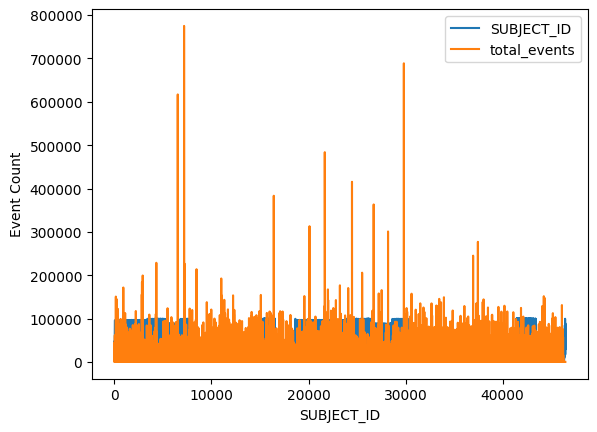

In [7]:
events_count_pd = events_count_df.toPandas()

events_count_pd.plot()
plt.ylabel('Event Count')
plt.xlabel('SUBJECT_ID')
plt.show()

### Distribution of ICU Stay Lengths (LOS)

To explore the distribution of ICU stay lengths (LOS), we first group the data by ``SUBJECT_ID``,``HADM_ID`` and ``ICUSTAY_ID`` and calculate the ``admission_time`` and ```discharge_time``` for each patient. Then, we calculate the LOS in hours and describe its statistics.

In [8]:
los_df = df.groupBy("SUBJECT_ID","HADM_ID","ICUSTAY_ID") \
    .agg(
        min("CHARTTIME").alias("admission_time"),
        max("CHARTTIME").alias("discharge_time")
    ) \
    .withColumn("LOS_hours", ((unix_timestamp("discharge_time") - unix_timestamp("admission_time")) / 3600).cast("int"))

los_df.show(5)

+----------+-------+----------+-------------------+-------------------+---------+
|SUBJECT_ID|HADM_ID|ICUSTAY_ID|     admission_time|     discharge_time|LOS_hours|
+----------+-------+----------+-------------------+-------------------+---------+
|     24586| 145340|    265334|2152-09-23 04:43:00|2152-09-26 13:38:00|       80|
|     25935| 188026|    244601|2121-03-16 01:47:00|2121-03-17 21:15:00|       43|
|     25876| 131372|    209266|2191-02-24 08:51:00|2191-02-25 06:52:00|       22|
|     27500| 141187|    210911|2173-10-08 01:00:00|2173-10-09 16:53:00|       39|
|     27790| 127130|    249511|2113-07-12 17:37:00|2113-07-14 00:11:00|       30|
+----------+-------+----------+-------------------+-------------------+---------+
only showing top 5 rows



We observed that:
* There are 62654 observations available for analysis
* The average LOS is approximately 113 hous ~ 4.7 days
* The standard deviation suggests that the LOS are widely spread out from the average
* The minimum LOS is 0 hours
* The maximum LOS is 17519 hours ~ 2 years

In [23]:
los_df.describe("LOS_hours").show()

+-------+------------------+
|summary|         LOS_hours|
+-------+------------------+
|  count|             62654|
|   mean|113.53680531171194|
| stddev|238.81173467985093|
|    min|                 0|
|    max|             17519|
+-------+------------------+



To determine if there is subjects with more than one hospital admission, we do a groupBy operation on the ``SUBJECT_ID`` column and then count the number of unique ``HADM_IDs`` for each ``SUBJECT_ID``. 

We discovered that 6515 patients had more than one hospital admission.

In [14]:
subjects_multiple_admissions = los_df.groupBy("SUBJECT_ID").agg(countDistinct("HADM_ID").alias("num_admissions")).filter(col("num_admissions") > 1)
subjects_multiple_admissions.describe("num_admissions").show()

+-------+------------------+
|summary|    num_admissions|
+-------+------------------+
|  count|              6515|
|   mean|2.6584804297774367|
| stddev|  1.65810959886756|
|    min|                 2|
|    max|                41|
+-------+------------------+



To determine if there is subjects with more than one ICU stay, we do a groupBy operation on the ``SUBJECT_ID`` column and then count the number of unique ``ICUSTAY_IDs`` for each ``SUBJECT_ID``. 

We discovered that 8436 patients had more than one ICU stay.

In [31]:
subjects_multiple_icu_stays = los_df.groupBy("SUBJECT_ID").agg(countDistinct("ICUSTAY_ID").alias("num_icu_stays")).filter(col("num_icu_stays") > 1)
subjects_multiple_icu_stays.describe("num_icu_stays").show()

+-------+------------------+
|summary|     num_icu_stays|
+-------+------------------+
|  count|              8436|
|   mean|2.7072072072072073|
| stddev|1.6789361311614799|
|    min|                 2|
|    max|                41|
+-------+------------------+



### Missing Values

In [38]:
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----------+-------+----------+------+---------+---------+-------+-------+---------+---------+---------+---------+------------+---------+
|ROW_ID|SUBJECT_ID|HADM_ID|ICUSTAY_ID|ITEMID|CHARTTIME|STORETIME|   CGID|  VALUE| VALUENUM| VALUEUOM|  WARNING|    ERROR|RESULTSTATUS|  STOPPED|
+------+----------+-------+----------+------+---------+---------+-------+-------+---------+---------+---------+---------+------------+---------+
|     0|         0|      0|    297529|     0|        0|  6312672|6312672|2071349|184208315|213982888|221315841|221315841|   321182823|110282285|
+------+----------+-------+----------+------+---------+---------+-------+-------+---------+---------+---------+---------+------------+---------+



In [46]:
icu_null = los_df.filter(col("ICUSTAY_ID").isNull())
print(f"The column ICUSTAY_ID has {icu_null.count()} null values.")

The column ICUSTAY_ID has 1661 null values.


In [36]:
icu_null.describe("LOS_hours").show()

+-------+-----------------+
|summary|        LOS_hours|
+-------+-----------------+
|  count|             1661|
|   mean|34.82781456953642|
| stddev|524.6768510665974|
|    min|                0|
|    max|            17519|
+-------+-----------------+



We have removed LOSs shorter than one hour as it is very likely that they were not in ICU.

In [47]:
icu_null = icu_null.filter(col("LOS_hours") >= 1)
icu_null.describe("LOS_hours").show()

+-------+------------------+
|summary|         LOS_hours|
+-------+------------------+
|  count|               429|
|   mean|134.84615384615384|
| stddev|1026.7320263078163|
|    min|                 1|
|    max|             17519|
+-------+------------------+



Let's take a look at the LOS equal to 17519. In this case, as the time is very similar, there was probably an error when entering the date.

In [48]:
los_17519_subjects = icu_null.filter(col("LOS_hours") == 17519)
los_17519_subjects.show()

+----------+-------+----------+-------------------+-------------------+---------+
|SUBJECT_ID|HADM_ID|ICUSTAY_ID|     admission_time|     discharge_time|LOS_hours|
+----------+-------+----------+-------------------+-------------------+---------+
|     53743| 136583|      NULL|2175-12-26 20:23:00|2177-12-25 20:00:00|    17519|
+----------+-------+----------+-------------------+-------------------+---------+



Therefore, this outlier has been removed.

Now we can observe that:
* There are 428 ICU stays null
* The average LOS is approximately 113 hous ~ 3.9 days
* The standard deviation suggests that the LOS are widely spread out from the average
* The minimum LOS is 1 hour
* The maximum LOS is 8360 hours ~ 11 months

In [49]:
icu_null = icu_null.filter(col("LOS_hours") != 17519)
icu_null.describe("LOS_hours").show()

+-------+-----------------+
|summary|        LOS_hours|
+-------+-----------------+
|  count|              428|
|   mean|94.22897196261682|
| stddev|589.2748760411961|
|    min|                1|
|    max|             8360|
+-------+-----------------+



### Duplicate Values

In [ ]:
#duplicate_rows_count = df.count() - df.distinct().count()

df.groupBy(df.columns)\
    .count()\
    .where(col('count') > 1)\
    .select(sum('count'))\
    .show()

#+----------+
#|sum(count)|
#+----------+
#|      NULL|
#+----------+

In [25]:
los_df.groupBy(los_df.columns)\
    .count()\
    .where(col('count') > 1)\
    .select(sum('count'))\
    .show()

+----------+
|sum(count)|
+----------+
|      NULL|
+----------+



In [9]:
spark.stop()